In [1]:
## These notebooks were written and placed in the root directory of a Django project that already
## has a database connection and schemas defined, to dispense with some of the setup busywork.
## The django imports are commented out, since they are meaningless outside of of this directory.
## To get the dataframes referred to in this notebook, begin with the unpickling four cells down.

# import os
# import matplotlib.pyplot as plt
# os.environ.setdefault("DJANGO_SETTINGS_MODULE", "resume_scanner.settings")
# os.environ["DJANGO_ALLOW_ASYNC_UNSAFE"] = "true"

# import django
# django.setup()

# from django.core.management import call_command
import json
from nltk.corpus import stopwords
from model.aggregator import *
import pickle
import re
import seaborn as sns
import time

skills = json.load(open('skill_dict.json'))
certs = [i.lower() for i in skills['Certification']]
hards = [i.lower() for i in skills['Hard Skill']]
softs = [i.lower() for i in skills['Soft Skill']]
skills = certs + hards + softs

pattern = re.compile(
    r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*'
)

In [2]:
## We reduce the two types of data that we have to just their skills to consolidate them in one dataframe
## This block takes roughly forty to run; the dataframes built from the resulting lists are pickled/unpickled
## later for convenience

start_time = time.time()

## return two strings: one containing resume's skills, one containing job's skills
def skills_from_resume(scan):
    resume_skills = ''
    job_skills = ''
    
    resume_cleaned = ' '.join(pattern.sub(
        '', scan.resume.lower().replace(',', ' ').replace('.', ' ').replace('(', ' ').replace(')', ' ')
    ).split())
    job_cleaned = ' '.join(pattern.sub(
        '', scan.job.lower().replace(',', ' ').replace('.', ' ').replace('(', ' ').replace(')', ' ')
    ).split())

    for i in skills:
        if ' ' + i + ' ' in resume_cleaned:
            resume_skills += ' ' + i
        if ' ' + i + ' ' in job_cleaned:
            job_skills += ' ' + i

    return [resume_skills, job_skills]

## return a string containing an applicant/post profile's skills
def skills_from_applicant_post(obj):
    obj_skills = ''
    
    obj_cleaned = ' '.join(pattern.sub(
        '', obj.algorithm_string.lower().replace(',', ' ').replace('.', ' ').replace('(', ' ').replace(')', ' ')
    ).split())
    
    for i in skills:
        if ' ' + i + ' ' in obj_cleaned:
            obj_skills += ' ' + i
    
    return obj_skills

## Build three lists: swipe_rows that contain all swipe data, scan_rows that contain all scan data,
## and rows that is simply the two put together

post_swipes = PostSwipe.objects.all()
applicant_swipes = ApplicantSwipe.objects.all()
scans = ResumeScan.objects.all()

rows = []
swipe_rows = []

for i in post_swipes:
    app_skills = skills_from_applicant_post(i.applicant)
    post_skills = skills_from_applicant_post(i.post)
    rows.append({
        'applicant': app_skills,
        'post': post_skills,
        'like': i.like
    })
    swipe_rows.append({
        'applicant': app_skills,
        'post': post_skills,
        'like': i.like
    })
    if len(swipe_rows) % 250 == 0:
        print(len(swipe_rows))
    
print('done with post_swipes')

for i in applicant_swipes:
    app_skills = skills_from_applicant_post(i.swiper)
    post_skills = skills_from_applicant_post(i.post)
    rows.append({
        'applicant': app_skills,
        'post': post_skills,
        'like': i.like
    })
    swipe_rows.append({
        'applicant': app_skills,
        'post': post_skills,
        'like': i.like
    })
    if len(swipe_rows) % 250 == 0:
        print(len(swipe_rows))
    
print('done with applicant swipes')
    
scan_rows = []

for i in scans:
    rs_skills = skills_from_resume(i)
    rows.append({
        'applicant': rs_skills[0],
        'post': rs_skills[1],
        'like': None
    })
    scan_rows.append({
        'applicant': rs_skills[0],
        'post': rs_skills[1],
        'like': None
    })
    if len(scan_rows) % 250 == 0:
        print(len(scan_rows))

print("--- Assembling rows done in %s seconds ---" % (time.time() - start_time))

250
done with post_swipes
500
750
1000
1250
done with applicant swipes
250
500
750
1000
1250
1500
1750
2000
2250
2500
2750
3000
3250
3500
3750
4000
4250
4500
4750
5000
5250
5500
5750
6000
6250
6500
6750
7000
7250
7500
7750
8000
8250
8500
8750
9000
9250
9500
9750
10000
10250
10500
10750
11000
11250
11500
11750
12000
12250
12500
12750
13000
13250
13500
13750
14000
--- Assembling rows done in 2649.4936714172363 seconds ---


In [3]:
## Given the three lists above, split them into their constituent applicant/job parts and
## feed them into TfidfVectorizers to get vectorized data for swipe posts, swipe applicants,
## scan posts, and scan applicants (these four are vectorized independently of each other),
## and combined swipe/scan posts/applicants

start_time = time.time()

swipe_df = pd.DataFrame(swipe_rows)
scan_df = pd.DataFrame(scan_rows)
combined_rows_df = pd.DataFrame(rows)

swipe_post_vectorizer = TfidfVectorizer(analyzer=ngram_lem, min_df=0.1) 
swipe_posts = swipe_post_vectorizer.fit_transform(swipe_df['post'])
print('finished vectorizing swipe posts')

swipe_applicant_vectorizer = TfidfVectorizer(analyzer=ngram_lem, min_df=0.1)
swipe_applicants = swipe_applicant_vectorizer.fit_transform(swipe_df['applicant'])
print('finished vectorizing swipe applicants')

scan_post_vectorizer = TfidfVectorizer(analyzer=ngram_lem, min_df=0.1)
scan_posts = scan_post_vectorizer.fit_transform(scan_df['post'])
print('finished vectorizing scan posts')

scan_applicant_vectorizer = TfidfVectorizer(analyzer=ngram_lem, min_df=0.1)
scan_applicants = scan_applicant_vectorizer.fit_transform(scan_df['applicant'])
print('finished vectorizing scan applicants')

combined_post_vectorizer = TfidfVectorizer(analyzer=ngram_lem, min_df=0.1)
combined_posts = combined_post_vectorizer.fit_transform(combined_rows_df['post'])
print('finished vectorizing combined posts')

combined_applicant_vectorizer = TfidfVectorizer(analyzer=ngram_lem, min_df=0.1)
combined_applicants = combined_applicant_vectorizer.fit_transform(combined_rows_df['applicant'])
print('finished vectorizing combined applicants')

print("--- Assembling rows and vectorizing done in %s seconds ---" % (time.time() - start_time))

finished vectorizing swipe posts
finished vectorizing swipe applicants
finished vectorizing scan posts
finished vectorizing scan applicants
finished vectorizing combined posts
finished vectorizing combined applicants
--- Assembling rows and vectorizing done in 874.124340057373 seconds ---


In [7]:
## Take the above six matrices and convert them into two final dataframes containing information
## on both job and applicant skills; one with features that were vectorized without taking into
## account swipe/scan status, and one that wasn't

df_vec_swipe_post = pd.DataFrame(
    swipe_posts.toarray(), columns=swipe_post_vectorizer.get_feature_names_out()
)
df_vec_swipe_app = pd.DataFrame(
    swipe_applicants.toarray(), columns=swipe_applicant_vectorizer.get_feature_names_out()
)

df_vec_scan_post = pd.DataFrame(
    scan_posts.toarray(), columns=scan_post_vectorizer.get_feature_names_out()
)
df_vec_scan_app = pd.DataFrame(
    scan_applicants.toarray(), columns=scan_applicant_vectorizer.get_feature_names_out()
)

combined_df_post = pd.DataFrame(
    combined_posts.toarray(), columns=combined_post_vectorizer.get_feature_names_out()
)
combined_df_app = pd.DataFrame(
    combined_applicants.toarray(), columns=combined_applicant_vectorizer.get_feature_names_out()
)

for i in df_vec_swipe_post:
    df_vec_swipe_post.rename(columns = {i: 'job_' + i}, inplace = True)
    
for i in df_vec_swipe_app:
    df_vec_swipe_app.rename(columns = {i: 'app_' + i}, inplace = True)

for i in df_vec_scan_post:
    df_vec_scan_post.rename(columns = {i: 'job_' + i}, inplace = True)
    
for i in df_vec_scan_app:
    df_vec_scan_app.rename(columns = {i: 'app_' + i}, inplace = True)
    
for i in combined_df_post:
    combined_df_post.rename(columns = {i: 'job_' + i}, inplace = True)
    
for i in combined_df_app:
    combined_df_app.rename(columns = {i: 'app_' + i}, inplace = True)

df_swipe = pd.concat([df_vec_swipe_post, df_vec_swipe_app], axis=1)
df_scan = pd.concat([df_vec_scan_post, df_vec_scan_app], axis=1)

seg_scan_swipe_df = pd.concat([df_swipe, df_scan], ignore_index=True).fillna(0)
seg_scan_swipe_df['like'] = [1 if i['like'] else 0 for i in swipe_rows] + [np.nan for i in range(df_scan.shape[0])]

combined_df = pd.concat([combined_df_post, combined_df_app], axis=1)
combined_df['like'] = [1 if i['like'] else 0 for i in swipe_rows] + [np.nan for i in range(df_scan.shape[0])]

seg_scan_swipe_df.to_pickle('seg_scan_swipe.pkl')
combined_df.to_pickle('combined.pkl')

In [2]:
seg_scan_swipe_df = pd.read_pickle('seg_scan_swipe.pkl')
combined_df = pd.read_pickle('combined.pkl')
unified_combined_df = pd.read_pickle('unified_combined.pkl')
unified_col_seg_df = pd.read_pickle('unified_col_seg.pkl')

In [3]:
## Take the dataframe with undiscriminated vectorizers and create a new dataframe that attempts
## to merge the job/applicant columns into one

skill_columns = [i for i in combined_df.columns if i != 'like']
skills = list(set([i[4:] for i in skill_columns]))

unified_combined_df = combined_df.copy(deep=True)
for i in skills:
    if 'job_' + i in unified_combined_df and 'app_' + i in unified_combined_df:
        unified_combined_df[i] = (unified_combined_df['job_' + i] 
                                 / unified_combined_df['app_' + i]
                                ).fillna(15).replace([np.inf, -np.inf], 15)
    elif 'job_' + i in unified_combined_df:
        unified_combined_df[i] = 15
    else:
        unified_combined_df[i] = 15
        
job_features = unified_combined_df.columns[unified_combined_df.columns.str.startswith('job_')]
app_features = unified_combined_df.columns[unified_combined_df.columns.str.startswith('app_')]
unified_combined_df.drop(job_features, axis=1, inplace=True)
unified_combined_df.drop(app_features, axis=1, inplace=True)
unified_combined_df.to_pickle('unified_combined.pkl')

In [4]:
## Take the dataframes with discriminated vectorizers and create a new dataframe that attempts
## to merge the job/applicant columns into one

skill_columns = [i for i in seg_scan_swipe_df.columns if i != 'like']
skills = list(set([i[4:] for i in skill_columns]))

unified_col_seg_df = seg_scan_swipe_df.copy(deep=True)
for i in skills:
    if 'job_' + i in unified_col_seg_df and 'app_' + i in unified_col_seg_df:
        unified_col_seg_df[i] = (unified_col_seg_df['job_' + i] 
                                 / unified_col_seg_df['app_' + i]
                                ).fillna(15).replace([np.inf, -np.inf], 15)
    elif 'job_' + i in unified_col_seg_df:
        unified_col_seg_df[i] = 15
    else:
        unified_col_seg_df[i] = 15
        
job_features = unified_col_seg_df.columns[unified_col_seg_df.columns.str.startswith('job_')]
app_features = unified_col_seg_df.columns[unified_col_seg_df.columns.str.startswith('app_')]
unified_col_seg_df.drop(job_features, axis=1, inplace=True)
unified_col_seg_df.drop(app_features, axis=1, inplace=True)
unified_col_seg_df.to_pickle('unified_col_seg.pkl')

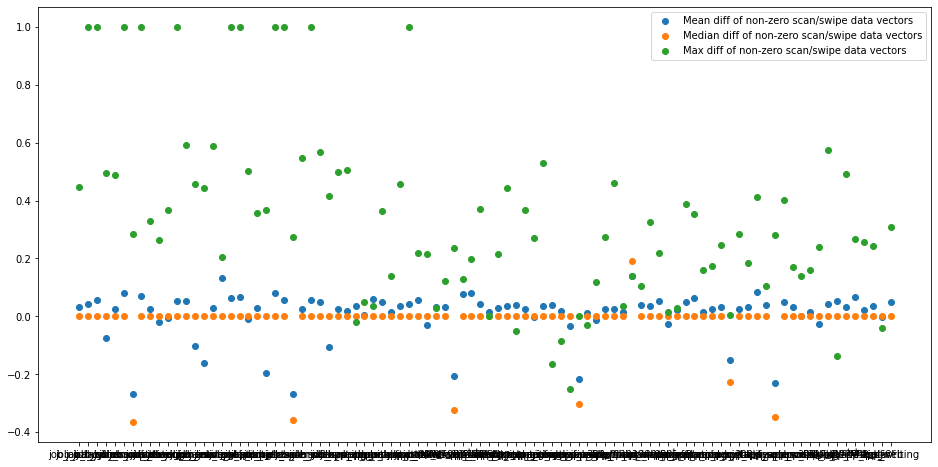

In [5]:
## Visual exploration of the difference between scan/swipe feature statistics
## when they were vectorized together

swipes_combined_df = combined_df[~combined_df.like.isna()].drop(columns=['like'])
scans_combined_df = combined_df[combined_df.like.isna()].drop(columns=['like'])
mean_diffs = []
med_diffs = []
max_diffs = []
for i in swipes_combined_df:
    mean_diffs.append(
        scans_combined_df[i].mean() 
        - swipes_combined_df[i].mean()
    )
    med_diffs.append(
        scans_combined_df[i].median() 
        - swipes_combined_df[i].median()
    )
    max_diffs.append(
        scans_combined_df[i].max()
        - swipes_combined_df[i].max()
    )
plt.figure(figsize=(16, 8))
plt.scatter(swipes_combined_df.columns, mean_diffs)
plt.scatter(swipes_combined_df.columns, med_diffs)
plt.scatter(swipes_combined_df.columns, max_diffs)

plt.legend([
    'Mean diff of non-zero scan/swipe data vectors', 
    'Median diff of non-zero scan/swipe data vectors',
    'Max diff of non-zero scan/swipe data vectors', 
])

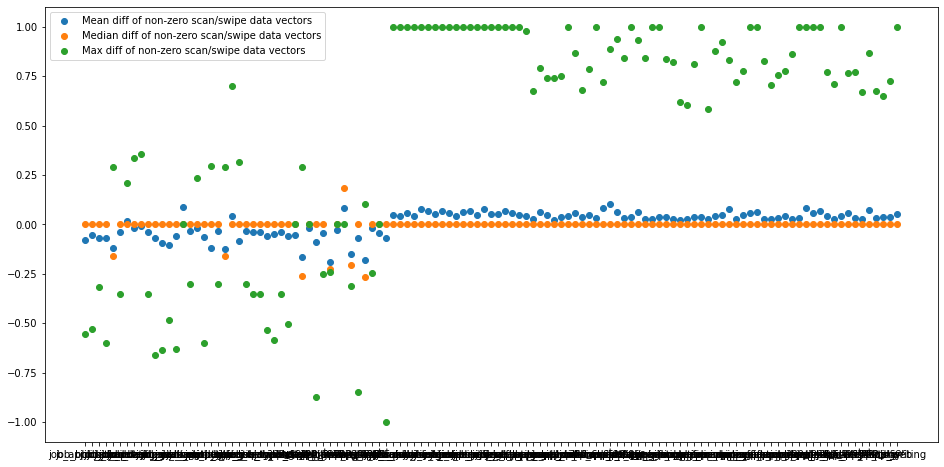

In [6]:
## Visual exploration of the difference between scan/swipe feature statistics
## when they were vectorized independently and then merged together

sep_mean_diffs = []
sep_med_diffs = []
sep_max_diffs = []
swipes_sep_vec_df = seg_scan_swipe_df[~seg_scan_swipe_df.like.isna()].drop(columns=['like'])
scans_sep_vec_df = seg_scan_swipe_df[seg_scan_swipe_df.like.isna()].drop(columns=['like'])
for i in swipes_sep_vec_df:
    sep_mean_diffs.append(
        scans_sep_vec_df[i].mean() 
        - swipes_sep_vec_df[i].mean()
    )
    sep_med_diffs.append(
        scans_sep_vec_df[i].median() 
        - swipes_sep_vec_df[i].median()
    )
    sep_max_diffs.append(
        scans_sep_vec_df[i].max() 
        - swipes_sep_vec_df[i].max()
    )

plt.figure(figsize=(16, 8))
plt.scatter(swipes_sep_vec_df.columns, sep_mean_diffs)
plt.scatter(swipes_sep_vec_df.columns, sep_med_diffs)
plt.scatter(swipes_sep_vec_df.columns, sep_max_diffs)
plt.legend([
    'Mean diff of non-zero scan/swipe data vectors', 
    'Median diff of non-zero scan/swipe data vectors', 
    'Max diff of non-zero scan/swipe data vectors'
])

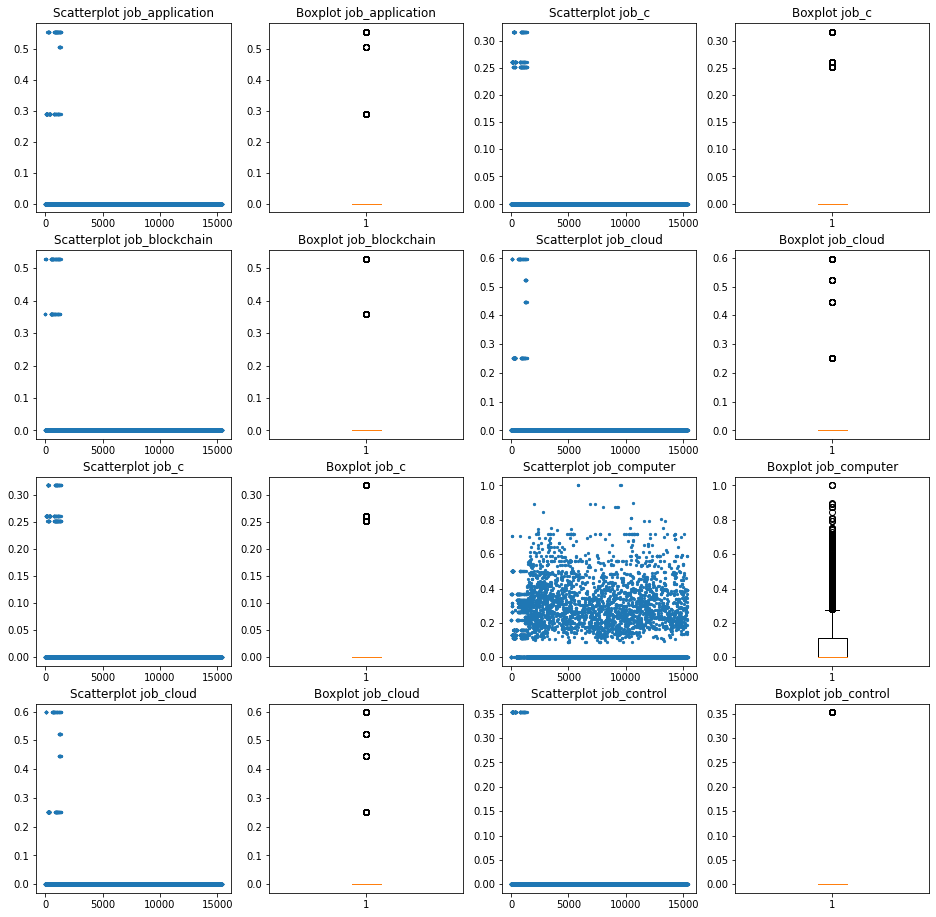

In [7]:
fig, axs = plt.subplots(4, 4, figsize=(16, 16))
x_range = range(seg_scan_swipe_df.shape[0])
for i in range(4):
    for j in range(2):
        column = seg_scan_swipe_df.columns[i + j*2]
        axs[i, 2*j].scatter(x_range, seg_scan_swipe_df[column], s=5)
        axs[i, 2*j].set_title('Scatterplot ' + column)
        axs[i, 2*j + 1].boxplot(seg_scan_swipe_df[column])
        axs[i, 2*j + 1].set_title('Boxplot ' + column)
plt.show()

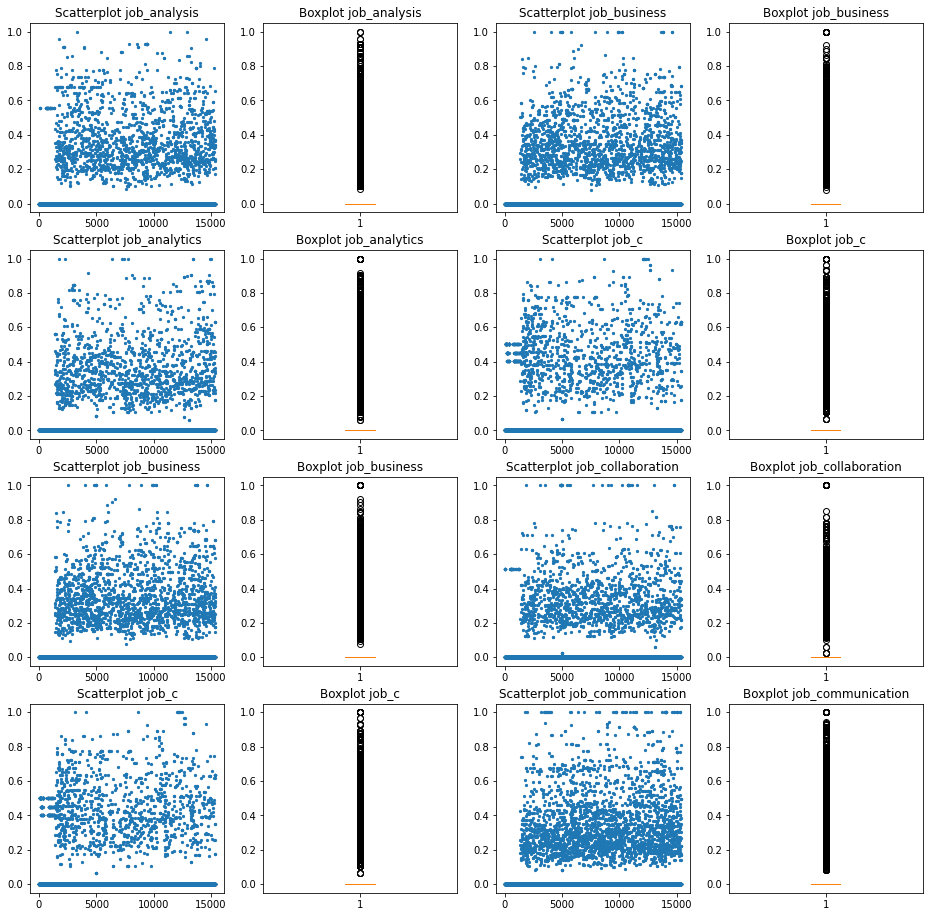

In [8]:
fig, axs = plt.subplots(4, 4, figsize=(16, 16))
x_range = range(combined_df.shape[0])
for i in range(4):
    for j in range(2):
        column = combined_df.columns[i + j*2]
        axs[i, 2*j].scatter(x_range, combined_df[column], s=5)
        axs[i, 2*j].set_title('Scatterplot ' + column)
        axs[i, 2*j + 1].boxplot(combined_df[column])
        axs[i, 2*j + 1].set_title('Boxplot ' + column)
plt.show()

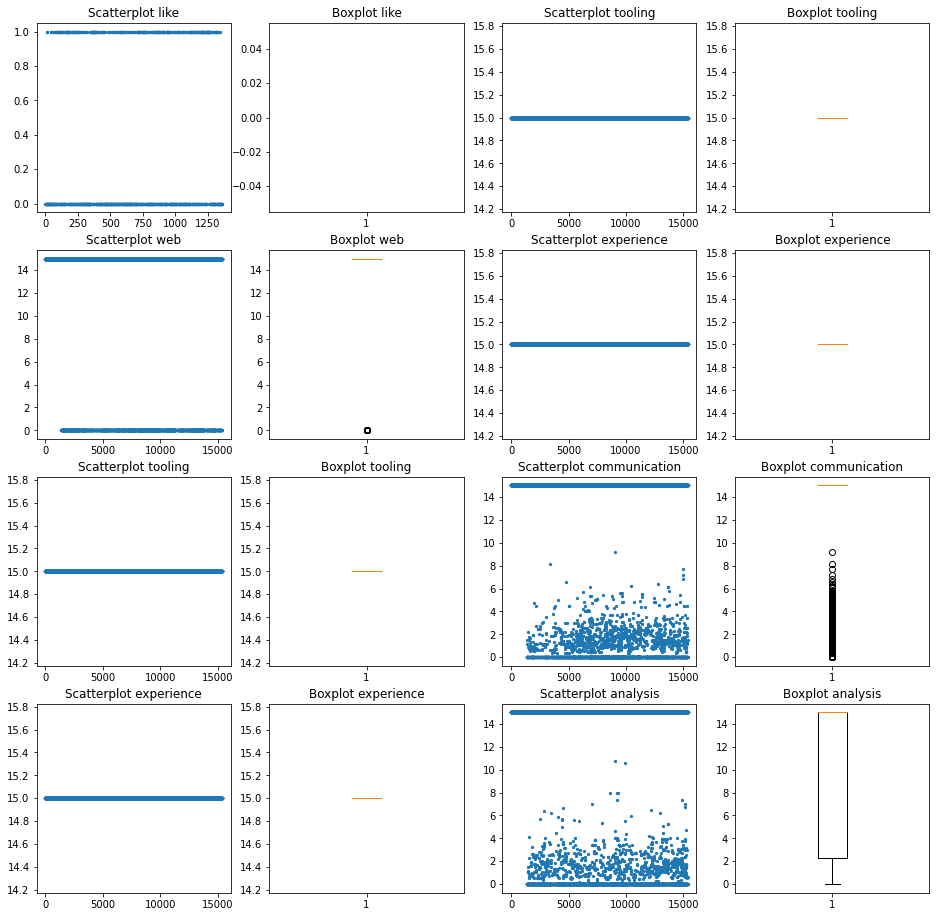

In [9]:
fig, axs = plt.subplots(4, 4, figsize=(16, 16))
x_range = range(unified_col_seg_df.shape[0])
for i in range(4):
    for j in range(2):
        column = unified_col_seg_df.columns[i + j*2]
        axs[i, 2*j].scatter(x_range, unified_col_seg_df[column], s=5)
        axs[i, 2*j].set_title('Scatterplot ' + column)
        axs[i, 2*j + 1].boxplot(unified_col_seg_df[column])
        axs[i, 2*j + 1].set_title('Boxplot ' + column)
plt.show()

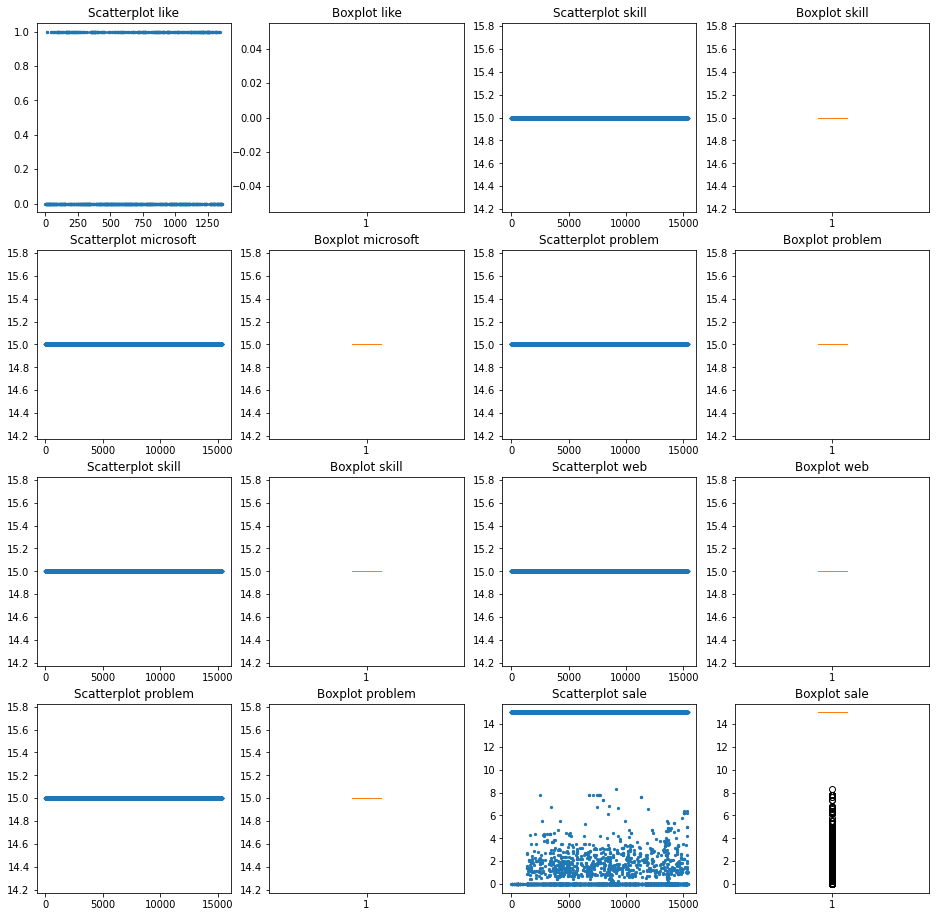

In [10]:
fig, axs = plt.subplots(4, 4, figsize=(16, 16))
x_range = range(unified_combined_df.shape[0])
for i in range(4):
    for j in range(2):
        column = unified_combined_df.columns[i + j*2]
        axs[i, 2*j].scatter(x_range, unified_combined_df[column], s=5)
        axs[i, 2*j].set_title('Scatterplot ' + column)
        axs[i, 2*j + 1].boxplot(unified_combined_df[column])
        axs[i, 2*j + 1].set_title('Boxplot ' + column)
plt.show()